# Transfer Learning

Most of the time you won't want to train a whole convolutional network yourself. Modern ConvNets training on huge datasets like ImageNet take weeks on multiple GPUs. 
> Instead, most people use a pretrained network either as a fixed feature extractor, or as an initial network to fine tune. 

In this notebook, you'll be using [VGGNet](https://arxiv.org/pdf/1409.1556.pdf) trained on the [ImageNet dataset](http://www.image-net.org/) as a feature extractor. Below is a diagram of the VGGNet architecture, with a series of convolutional and maxpooling layers, then three fully-connected layers at the end that classify the 1000 classes found in the ImageNet database.

<img src="notebook_ims/vgg_16_architecture.png" width=700px>

VGGNet is great because it's simple and has great performance, coming in second in the ImageNet competition. The idea here is that we keep all the convolutional layers, but **replace the final fully-connected layer** with our own classifier. This way we can use VGGNet as a _fixed feature extractor_ for our images then easily train a simple classifier on top of that. 
* Use all but the last fully-connected layer as a fixed feature extractor.
* Define a new, final classification layer and apply it to a task of our choice!

You can read more about transfer learning from [the CS231n Stanford course notes](http://cs231n.github.io/transfer-learning/).

---

## Flower power

Here we'll be using VGGNet to classify images of flowers. We'll start, as usual, by importing our usual resources. And checking if we can train our model on GPU.

### Download Data

The flower data is available in a zip file in this lesson's resources, for download to your local environment. In the case of this notebook, the data is already downloaded and in the directory `flower_photos/`.

In [1]:
import os
import numpy as np
import torch

import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Load and Transform our Data

We'll be using PyTorch's [ImageFolder](https://pytorch.org/docs/stable/torchvision/datasets.html#imagefolder) class which makes is very easy to load data from a directory. For example, the training images are all stored in a directory path that looks like this:
```
root/class_1/xxx.png
root/class_1/xxy.png
root/class_1/xxz.png

root/class_2/123.png
root/class_2/nsdf3.png
root/class_2/asd932_.png
```

Where, in this case, the root folder for training is `flower_photos/train/` and the classes are the names of flower types.

In [3]:
# define training and test data directories
data_dir = 'flower_photos/'
train_dir = os.path.join(data_dir, 'train/')
test_dir = os.path.join(data_dir, 'test/')

# classes are folders in each directory with these names
classes = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

### Transforming the Data

When we perform transfer learning, we have to shape our input data into the shape that the pre-trained model expects. VGG16 expects `224`-dim square images as input and so, we resize each flower image to fit this mold.

In [4]:
# load and transform data using ImageFolder

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transform = transforms.Compose([transforms.RandomResizedCrop(224), 
                                      transforms.ToTensor()])

train_data = datasets.ImageFolder(train_dir, transform=data_transform)
test_data = datasets.ImageFolder(test_dir, transform=data_transform)

# print out some data stats
print('Num training images: ', len(train_data))
print('Num test images: ', len(test_data))

Num training images:  3130
Num test images:  540


### DataLoaders and Data Visualization

In [5]:
# define dataloader parameters
batch_size = 20
num_workers=0

# prepare data loaders
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, 
                                           num_workers=num_workers, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, 
                                          num_workers=num_workers, shuffle=True)

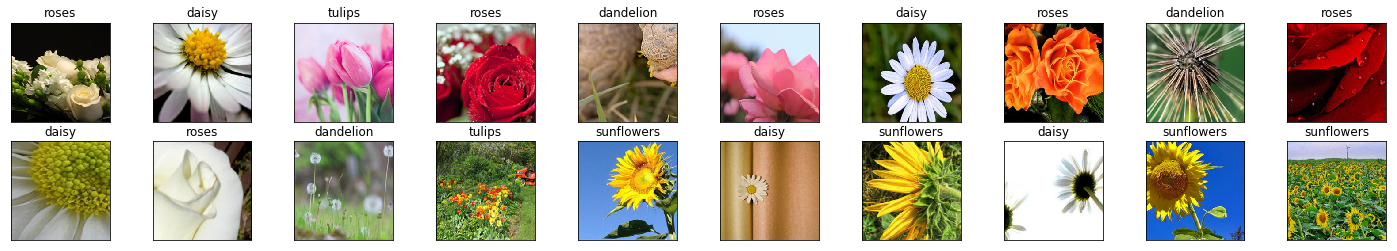

In [6]:
# Visualize some sample data

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title(classes[labels[idx]])

---
## Define the Model

To define a model for training we'll follow these steps:
1. Load in a pre-trained VGG16 model
2. "Freeze" all the parameters, so the net acts as a fixed feature extractor 
3. Remove the last layer
4. Replace the last layer with a linear classifier of our own

**Freezing simply means that the parameters in the pre-trained model will *not* change during training.**

In [7]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16(pretrained=True)

# print out the model structure
print(vgg16)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.torch/models/vgg16-397923af.pth
100%|██████████| 553433881/553433881 [00:05<00:00, 105127950.92it/s]


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

In [8]:
print(vgg16.classifier[6].in_features) 
print(vgg16.classifier[6].out_features) 


4096
1000


In [9]:
# Freeze training for all "features" layers
for param in vgg16.features.parameters():
    param.requires_grad = False
    

---
### Final Classifier Layer

Once you have the pre-trained feature extractor, you just need to modify and/or add to the final, fully-connected classifier layers. In this case, we suggest that you repace the last layer in the vgg classifier group of layers. 
> This layer should see as input the number of features produced by the portion of the network that you are not changing, and produce an appropriate number of outputs for the flower classification task.

You can access any layer in a pretrained network by name and (sometimes) number, i.e. `vgg16.classifier[6]` is the sixth layer in a group of layers named "classifier".

#### TODO: Replace the last fully-connected layer with one that produces the appropriate number of class scores.

In [10]:
from torch import nn

In [11]:
## TODO: add a last linear layer  that maps n_inputs -> 5 flower classes
## new layers automatically have requires_grad = True

#f_classifier = nn.Sequential(nn.Linear(25088, 1024),
#                             nn.ReLU(),
#                             nn.Linear(1024, 64),
#                             nn.ReLU(),
#                             nn.Linear(64, 5))


vgg16.classifier[6] = nn.Linear(4096, 5, bias=True)


# after completing your model, if GPU is available, move the model to GPU
if train_on_gpu:
    vgg16.cuda()

### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)

Below we'll use cross-entropy loss and stochastic gradient descent with a small learning rate. Note that the optimizer accepts as input _only_ the trainable parameters `vgg.classifier.parameters()`.

In [12]:
import torch.optim as optim

# specify loss function (categorical cross-entropy)
criterion = nn.CrossEntropyLoss()

# specify optimizer (stochastic gradient descent) and learning rate = 0.001
optimizer = optim.SGD(vgg16.classifier.parameters(), lr=0.001)

---
## Training

Here, we'll train the network.

> **Exercise:** So far we've been providing the training code for you. Here, I'm going to give you a bit more of a challenge and have you write the code to train the network. Of course, you'll be able to see my solution if you need help.

In [13]:
# number of epochs to train the model
n_epochs = 1

## TODO complete epoch and training batch loops
## These loops should update the classifier-weights of this model
## And track (and print out) the training loss over time

# Iterate through epochs
for e in range(n_epochs):
    # Specify Running losses to get loss after each epoch for both train & val
    train_loss = 0
    val_loss = 0
    
    # Iterate through training set
    for images, labels in train_loader:
        # Switch device if training on GPU:
        if train_on_gpu:
            images, labels = images.cuda(), labels.cuda()
        # Switch to training mode
        vgg16.train()
        # Zero grads
        optimizer.zero_grad()
        # Implement forward step
        output = vgg16.forward(images)
        # Calc loss
        loss = criterion(output, labels)
        # Calc Gradient of the loss w/ respect to grads collected during forward pass
        loss.backward()
        # Update weights
        optimizer.step()
        # Update train loss times the amount of images to make sure it gets augmented by less for smaller batches
        train_loss += loss.item() * images.size(0)
        
        
        for images, labels in test_loader:
            
            # Switch device if training on GPU:
            if train_on_gpu:
                images, labels = images.cuda(), labels.cuda()
            # Switch to eval mode
            vgg16.eval()
            # Forward pass
            output = vgg16.forward(images)
            # Calc loss
            loss = criterion(output, labels)
            # Update val loss
            val_loss += loss.item() * images.size(0)
            
        # Calc Avg Losses
        train_loss = train_loss / len(train_loader)
        val_loss = val_loss / len(test_loader)
        
        # Printing statement:
        print('Epoch: {}/{} \t Train Loss: {} \t Validation Loss: {}'.format(e + 1, n_epochs, train_loss, val_loss))
        
            
        
        
        
        
        
    






tensor(1.7049, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.21718092025465266 	 Validation Loss: 32.73927441349736
tensor(1.7198, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.22046888376124768 	 Validation Loss: 33.62164859091467
tensor(1.6710, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.21426676719968538 	 Validation Loss: 33.481979592389244
tensor(1.5660, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.20085199617084076 	 Validation Loss: 33.426969147896564
tensor(1.6847, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.21588900185078927 	 Validation Loss: 32.799475108295894
tensor(1.6961, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.21744206316762482 	 Validation Loss: 32.6377398848059
tensor(1.7154, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.2199051761556009 	 Validation Loss: 32.370985728279756
tensor(1.6312, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.20919114793177643 	 Validation Loss: 32.16792985177982
tensor(1.6378, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.20997486489371106 	 Validat

KeyboardInterrupt: 

In [ ]:
tensor(1.7049, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.21718092025465266 	 Validation Loss: 32.73927441349736
tensor(1.7198, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.22046888376124768 	 Validation Loss: 33.62164859091467
tensor(1.6710, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.21426676719968538 	 Validation Loss: 33.481979592389244
tensor(1.5660, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.20085199617084076 	 Validation Loss: 33.426969147896564
tensor(1.6847, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.21588900185078927 	 Validation Loss: 32.799475108295894
tensor(1.6961, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.21744206316762482 	 Validation Loss: 32.6377398848059
tensor(1.7154, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.2199051761556009 	 Validation Loss: 32.370985728279756
tensor(1.6312, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.20919114793177643 	 Validation Loss: 32.16792985177982
tensor(1.6378, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.20997486489371106 	 Validation Loss: 32.066762861049085
tensor(1.5549, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.19941981190438962 	 Validation Loss: 31.93114953337024
tensor(1.7606, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.22555451076463504 	 Validation Loss: 31.510080392381994
tensor(1.5032, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.1929214869133502 	 Validation Loss: 31.307722959077704
tensor(1.5668, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.20081482322997593 	 Validation Loss: 31.266782086320728
tensor(1.5005, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.1924274505571693 	 Validation Loss: 30.99052640395503
tensor(1.5432, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.19780596232806305 	 Validation Loss: 30.8486551607822
tensor(1.3926, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.17865794227232057 	 Validation Loss: 30.817571725982113
tensor(1.4823, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.18997020132511977 	 Validation Loss: 30.53111654176159
tensor(1.4452, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.18531325937881402 	 Validation Loss: 30.361973128809545
tensor(1.6085, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.20608687878424287 	 Validation Loss: 29.95653757644634
tensor(1.4738, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.18905460609756802 	 Validation Loss: 30.006162814591015
tensor(1.4018, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.17977359566805992 	 Validation Loss: 29.70294138871202
tensor(1.5237, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.19524994186748354 	 Validation Loss: 29.752822504029808
tensor(1.4951, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.19170283908627528 	 Validation Loss: 29.35665962819649
tensor(1.5454, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.1980869785004982 	 Validation Loss: 29.078079814426836
tensor(1.2997, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.16682648659704985 	 Validation Loss: 29.085196799507578
tensor(1.3174, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.16888380202524214 	 Validation Loss: 28.759276313048485
tensor(1.4001, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.17943517418632032 	 Validation Loss: 28.511727012324553
tensor(1.4767, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.1892540647252052 	 Validation Loss: 28.558008588284927
tensor(1.4346, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.18395560422625995 	 Validation Loss: 28.350055302989727
tensor(1.4543, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.18642834907372077 	 Validation Loss: 28.311819150337918
tensor(1.4744, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.18900380342664735 	 Validation Loss: 27.989669166755135
tensor(1.3871, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.1779030074112394 	 Validation Loss: 28.10618551876631
tensor(1.5540, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.1990932860884651 	 Validation Loss: 27.677170933141564
tensor(1.3843, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.17761738857070958 	 Validation Loss: 27.560009592140684
tensor(1.3068, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.16760021459274488 	 Validation Loss: 27.675016530993727
tensor(1.4993, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.1920568050859342 	 Validation Loss: 27.419534016856556
tensor(1.2959, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.16630938801157877 	 Validation Loss: 27.236423326466152
tensor(1.3016, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.16687335805737216 	 Validation Loss: 27.39276752916875
tensor(1.3241, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.16974418420426174 	 Validation Loss: 26.918352042468943
tensor(1.4198, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.1819437912479095 	 Validation Loss: 26.97098212458589
tensor(1.3936, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.17868682468226954 	 Validation Loss: 26.607992015141722
tensor(1.2752, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.16358334071091352 	 Validation Loss: 26.337870909912294
tensor(1.3875, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.17779339386441473 	 Validation Loss: 26.240745185118502
tensor(1.2439, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.1595948601119216 	 Validation Loss: 26.278283088233056
tensor(1.3702, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.17555838080750436 	 Validation Loss: 26.2337596140094
tensor(1.2210, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.15665894893909632 	 Validation Loss: 26.0509965409533
tensor(1.1214, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.143855370163418 	 Validation Loss: 25.611368894539115
tensor(1.1810, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.151356956995973 	 Validation Loss: 25.469959550432282
tensor(1.2519, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.1604402248876961 	 Validation Loss: 25.656305447527362
tensor(1.0823, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.13889633937551318 	 Validation Loss: 25.28065102686516
tensor(1.2387, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.15868313520854913 	 Validation Loss: 25.44016172024572
tensor(1.2140, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.15565639135752174 	 Validation Loss: 24.853785056219042
tensor(1.2550, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.160862686109993 	 Validation Loss: 24.904227080843537
tensor(1.3759, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.17629952492653472 	 Validation Loss: 25.14397408575562
tensor(1.2345, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.1583798429808001 	 Validation Loss: 24.916129872390794
tensor(1.1399, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.14622201313476463 	 Validation Loss: 24.64054375390908
tensor(1.2376, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.15859359324294167 	 Validation Loss: 24.593809456553245
tensor(1.3221, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.16942778930924232 	 Validation Loss: 24.5887197686907
tensor(1.1969, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.15355096752387082 	 Validation Loss: 24.243693490211154
tensor(1.2252, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.1570522396994081 	 Validation Loss: 24.42850329770659
tensor(1.1836, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.15177549805182589 	 Validation Loss: 24.463929636351125
tensor(1.2673, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.16240085398100101 	 Validation Loss: 24.0518520313675
tensor(1.0274, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.1319082505406178 	 Validation Loss: 24.070118040354807
tensor(1.2726, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.16295576293434386 	 Validation Loss: 24.123658227718604
tensor(1.3021, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.16691193612259447 	 Validation Loss: 23.793217042632925
tensor(1.1274, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.14468656133136437 	 Validation Loss: 23.86154674083907
tensor(1.2720, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.1629565467089428 	 Validation Loss: 23.66742598517107
tensor(1.2672, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.16246464494791382 	 Validation Loss: 23.656876170894016
tensor(0.8631, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.11097816313932446 	 Validation Loss: 23.577721563543086
tensor(1.2800, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.16376795457968732 	 Validation Loss: 23.550153987185645
tensor(1.5166, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.19424593765563328 	 Validation Loss: 23.623551704875354
tensor(1.0827, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.1391618821473528 	 Validation Loss: 23.373849545672783
tensor(0.9697, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.12441066760005187 	 Validation Loss: 23.11452477635996
tensor(1.2628, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.16165785905017604 	 Validation Loss: 23.545710631896707
tensor(1.1992, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.15379164963747377 	 Validation Loss: 23.326015457278775
tensor(0.9425, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.1210369561602979 	 Validation Loss: 22.917436890571437
tensor(1.1692, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.14970831930162187 	 Validation Loss: 22.946099548162103
tensor(1.0429, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.1338047316157591 	 Validation Loss: 22.949080441786222
tensor(0.9634, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.12357712964500576 	 Validation Loss: 22.63438290925649
tensor(1.3555, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.1734571852489316 	 Validation Loss: 22.674888882582508
tensor(1.3195, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.16919725589071616 	 Validation Loss: 22.484662375094903
tensor(1.0335, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.1327319125873594 	 Validation Loss: 22.647555575004418
tensor(1.0325, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.1323745022790338 	 Validation Loss: 22.32240374828677
tensor(1.0294, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.13197323152883336 	 Validation Loss: 22.43052524399805
tensor(1.1142, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.14277364927172556 	 Validation Loss: 21.93441825224737
tensor(0.8768, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.11260666070961647 	 Validation Loss: 22.249322937268452
tensor(1.0721, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.137289385229829 	 Validation Loss: 22.314809465347192
tensor(1.1197, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.14350947820096563 	 Validation Loss: 22.00550021595199
tensor(0.9628, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.12356582322463294 	 Validation Loss: 21.798630004262645
tensor(0.9941, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.1274271795348975 	 Validation Loss: 21.800804191354455
tensor(1.1149, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.1428363252275794 	 Validation Loss: 21.88277081403922
tensor(1.1329, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.1452293957422453 	 Validation Loss: 21.96540261336086
tensor(1.1301, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.14488379095083478 	 Validation Loss: 21.7211789647105
tensor(0.9653, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.12388467282082663 	 Validation Loss: 21.626961123646637
tensor(1.0701, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.13710636998248113 	 Validation Loss: 21.481647884834747
tensor(1.2289, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.15742381787762216 	 Validation Loss: 21.658128956070247
tensor(1.0538, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.13523838831212015 	 Validation Loss: 21.656880572221553
tensor(0.9520, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.12213114858896275 	 Validation Loss: 21.355594359606204
tensor(1.0908, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.1397302730296847 	 Validation Loss: 21.38477197262864
tensor(1.0234, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.1312579945289246 	 Validation Loss: 21.16554944271409
tensor(0.8215, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.10548577328621907 	 Validation Loss: 21.324672731556483
tensor(1.0493, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.13434375076664098 	 Validation Loss: 21.4064333627547
tensor(1.0917, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.13992169637014232 	 Validation Loss: 21.19426417420648
tensor(1.0779, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.13820001901452264 	 Validation Loss: 20.914101044362834
tensor(1.0801, device='cuda:0')
Epoch: 1/2 	 Train Loss: 0.13847602080775323 	 Validation Loss: 20.905849824717976


---
## Testing

Below you see the test accuracy for each flower class.

In [14]:
# track test loss 
# over 5 flower classes
test_loss = 0.0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))

vgg16.eval() # eval mode

# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = vgg16(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update  test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# calculate avg test loss
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.976735

Test Accuracy of daisy: 69% (64/92)
Test Accuracy of dandelion: 92% (122/132)
Test Accuracy of roses: 56% (51/91)
Test Accuracy of sunflowers: 66% (67/101)
Test Accuracy of tulips: 70% (88/124)

Test Accuracy (Overall): 72% (392/540)


### Visualize Sample Test Results

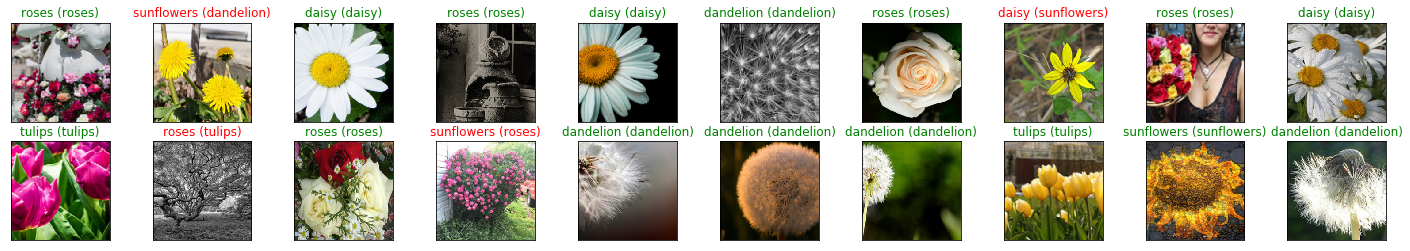

In [15]:
# obtain one batch of test images
dataiter = iter(test_loader)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = vgg16(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    plt.imshow(np.transpose(images[idx], (1, 2, 0)))
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))